# PageRank

#### Librerías utilizadas

In [1]:
import numpy as np
import math
import pandas as pd
from scipy.sparse import csr_matrix 
  
# Para las pruebas
from pytest import approx
import pprint

# Para los grafos
import networkx as nx
import matplotlib.pyplot as plt

## Definimos una set para practicar (por ahora 4 páginas)

Donde podemos observar en la columnas:
- `pagina`: la página a la que hace referencia.
- `outlinks`: los links a los que cada `pagina` hace referencia.

In [2]:
pages_links = pd.DataFrame(columns=['pagina','outlinks'])

In [3]:
pages_links['pagina'] = ['A', 'B', 'C', 'D']

In [4]:
pages_links['outlinks'][0] = ['C', 'B']

In [5]:
pages_links['outlinks'][1] = ['D']

In [6]:
pages_links['outlinks'][2] = ['A', 'B', 'D']

In [7]:
pages_links['outlinks'][3] = ['C']

In [8]:
pages_links

,pagina,outlinks
0,A,"[C, B]"
1,B,[D]
2,C,"[A, B, D]"
3,D,[C]


## Definimos un grafo pequeño de acuerdo a los datos anteriores

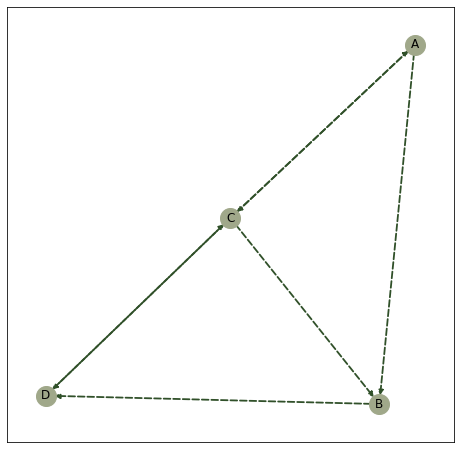

In [9]:
nodos = pages_links['pagina']

plt.figure(figsize=(8,8))
G = nx.DiGraph()

for nodo in nodos:
    G.add_node(nodo)
    
for page, outlinks in zip(pages_links['pagina'],pages_links['outlinks']):
    for outlink in outlinks:
        G.add_edge(page, outlink)

pos = nx.spring_layout(G)


nx.draw_networkx_nodes(G, pos, node_color='#a0a88a', node_size=400)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='#305029', width=1.8, arrows = True, style='dashed')

plt.show()

### Definimos nuestra matriz estocástica conforme a lo visto en el grafo:

In [10]:
sparseMatrix = csr_matrix((len(pages_links), len(pages_links)),  
                          dtype = np.float).toarray() 

In [11]:
newdf = pd.DataFrame(sparseMatrix, columns = pages_links['pagina'], index=pages_links['pagina'])

In [12]:
count = 0
for page, outlinks in zip(pages_links['pagina'],pages_links['outlinks']):
    score = 1/len(outlinks)
    dict_page = {page: np.zeros(len(pages_links))}
    for outlink in outlinks:
        newdf[page][outlink] = score

In [13]:
newdf

pagina,A,B,C,D
pagina,,,,
A,0.0,0.0,0.333333,0.0
B,0.5,0.0,0.333333,0.0
C,0.5,0.0,0.000000,1.0
D,0.0,1.0,0.333333,0.0


In [14]:
H = newdf.to_numpy()

In [15]:
pd.DataFrame(newdf)

pagina,A,B,C,D
pagina,,,,
A,0.0,0.0,0.333333,0.0
B,0.5,0.0,0.333333,0.0
C,0.5,0.0,0.000000,1.0
D,0.0,1.0,0.333333,0.0


## Probamos la obtención de Eigenvectores con Factorización QR (algoritmo desarrollado en la práctica 1.2)

In [16]:
def sign(x):
    """
    Helper function for computing sign of real number x.
    """
    if x >= 0:
        return 1
    else:
        return -1

In [17]:
def inverse_matrix(A):
    """
    Helper function for computing the inverse of matrix A nxn.
    """
    inv_temp = []
    
    for i in range (0,A.shape[0]): 
        e1 = np.zeros((A.shape[0],1))
        e1[i] = 1
        A_inv_i = np.linalg.solve(A.T, e1)
        inv_temp.append(A_inv_i)  
        
    for j in range (0,len(inv_temp)-1):
        if j == 0:
            r_inv = np.row_stack((inv_temp[j].T, inv_temp[j+1].T))
        else:
            r_inv = np.row_stack((r_inv, inv_temp[j+1].T))
        
    return(r_inv)

In [18]:
def off(T):
    """
    Helper function for computing off(T).
    """
    mask = np.ones(T.shape, dtype = bool)
    np.fill_diagonal(mask, 0)
    T_sin_dig = T[mask]
    sum = 0
    for i in range (0,len(T_sin_dig)):
        # print (T_sin_dig[i])
        sum += T_sin_dig[i]**2
    off_T = np.sqrt(sum)
    
    return(off_T)

In [19]:
def QR_Householder(A):
    """
    Decompose a real square matrix A where: A = QR usign Householder reflections.
    Args:
        A (numpy ndarray): Matrix in which QR algorithm will be performed.
    Returns:
        Q (numpy ndarray): orthogonal matrix (its columns are orthogonal unit vectors meaning
                            Q.TQ = QQ.T = I)
        R (numpy ndarray): upper triangular matrix.
    """
    a_aux = []
    
    for j in range (0,A.shape[0]-1):          #Asumimos que A SIEMPRE será cuadrada
        e = np.zeros((A.shape[0]-j, 1))
        e[0] = 1
        if j == 0:
            v = A[:,0] + sign(A[0,0])*np.linalg.norm(A[:,0])*e.T[0]
            beta = 2/v.dot(v)
            aux = A[:,0:] - beta*np.outer(v,v.dot(A[:,0:]))
            a_aux.append(aux)
        else:
            v = aux[1:,1] + sign(aux[1,1])*np.linalg.norm(aux[1:,1])*e.T[0]
            beta = 2/v.dot(v)  
            aux = aux[1:,1:] - beta*np.outer(v,v.dot(aux[1:,1:]))
            a_aux.append(aux)
    
    n,n = A.shape
    count = 0
    
    if n == 2:
        R = a_aux[0]
    else:
        for h in range(n-2,0,-1):
            if count == 0:
                temp_col = np.column_stack((np.zeros(2 + count), a_aux[h]))
            else:
                temp_col = np.column_stack((np.zeros(2 + count), temp_row))
            temp_row = np.row_stack((a_aux[h-1][0, 0:], temp_col))
            count += 1
        R = temp_row
    R_inv = inverse_matrix(R)
    
    Q = A@R_inv   
    
    return (Q,R)

In [20]:
def Eig_Householder(A):
    """
    Compute QR algorithm usign Householder reflections multiple times to approximate eigenvalues and 
    eigenvectors of A.
    Args:
        A (numpy ndarray): Symmetric matrix 
    Returns:
        evalues (numpy ndarray): Array with eigenvalues of matrix A.
        evectors (numpy ndarray): Matrix with eigenvectors of matrix A on its columns.
    """
    tol = 10e-8
    max_iters = 2000
    tk_fro_norm = np.linalg.norm(A, 'fro')
    iterations = 0
    off_Tk = off(A)
    
    q_aux = []
    
    while off_Tk > tol*tk_fro_norm and iterations < max_iters:
        iterations += 1
        if iterations == 1:
            Tk_minus1 = A
        else:
            Tk_minus1 = Tk
        
        q,r = QR_Householder(Tk_minus1)    
        q_aux.append(q)
        
        Tk = r@q
        
        off_Tk = off(Tk)
        tk_fro_norm = np.linalg.norm(Tk, 'fro')
    
    #Multiplicación Q0*Q1...Qn para cálculo de eigenvectores
    for g in range(0,len(q_aux)-1,1):
        if g == 0:
            q_temp = q_aux[g]@q_aux[g+1]
        else:
            q_temp = q_temp@q_aux[g+1]
    
    if iterations == 0:
        evalues = "error"
        evectors = "error"
    else:
        evectors = q_temp
        evalues = np.diag(Tk)
    
    return (evalues,evectors)

In [21]:
eigval, eigvec = Eig_Householder(H)

In [22]:
pd.DataFrame(eigval)

,0
0,1.000000
1,-0.626538
2,-0.357205
3,-0.016257


In [23]:
pd.DataFrame(eigvec)

,0,1,2,3
0,0.232495,0.529635,0.237150,-0.780508
1,0.348743,0.192872,0.785518,0.473434
2,0.697486,-0.672574,0.004505,-0.247260
3,0.581238,0.479512,-0.571577,0.324855


#### No olvidemos comprobar que los eigenvalores y eigenvectores sean los esperados

In [24]:
eigval_eig , eigvec_eig = np.linalg.eig(H)

In [25]:
pd.DataFrame(eigval_eig)

,0
0,1.000000+0.000000j
1,-0.626538+0.000000j
2,-0.186731+0.480774j
3,-0.186731-0.480774j


In [26]:
pd.DataFrame(eigvec_eig)

,0,1,2,3
0,-0.232495+0.000000j,0.445747+0.000000j,0.146497+0.377184j,0.146497-0.377184j
1,-0.348743+0.000000j,0.090025+0.000000j,0.435929+0.112414j,0.435929-0.112414j
2,-0.697486+0.000000j,-0.837833+0.000000j,-0.626088+0.000000j,-0.626088-0.000000j
3,-0.581238+0.000000j,0.302061+0.000000j,0.043661-0.489599j,0.043661+0.489599j


## Probamos con un Método de la Potencia adaptado a PageRank (obtenido de [Global Software Support](https://www.youtube.com/watch?v=kSmQbVxqOJc&feature=emb_title))

Este método de la potencia se define como: 
    
$$ PR_{t+1} = H PR_t $$

Donde:
- $H$: la matriz estocástica.
- $PR$: PageRank de la página indicada.

#### Definimos un vector inicial 

El vector será de tamaño $n$ (número de nodos) y la inicialización de cada valor será $1/n$.

En este caso:

\begin{align}
    v &= \begin{bmatrix}
           1/4 \\
           1/4 \\
           1/4 \\
           1/4
         \end{bmatrix}
  \end{align}

In [27]:
v = np.ones(len(pages_links))

In [28]:
v = v*1/len(v)

In [29]:
pprint.pprint(v)

array([0.25, 0.25, 0.25, 0.25])


Para obtener el segundo vector se debe hacer:
    
$$v_2 = Hv$$

In [30]:
v_2 = H@v

pprint.pprint(v_2)

array([0.08333333, 0.20833333, 0.375     , 0.33333333])


Para obtener el tercer vector:
    
$$ v_3 = Hv_2 = H(Hv) = H^2v$$

In [31]:
v_3  = H@v_2

pprint.pprint(v_3)

array([0.125     , 0.16666667, 0.375     , 0.33333333])


In [32]:
v_3_r = (H@H)@v

pprint.pprint(v_3_r)

array([0.125     , 0.16666667, 0.375     , 0.33333333])


Entonces, observamos que se puede representar de la forma: 
$$v_n = H^{n}v$$

Si iteramos varias veces tiende a un valor equilibrado:

In [33]:
n = 20
H = np.linalg.matrix_power(H, n)
v_n = H@v

In [34]:
v_n

array([0.12500368, 0.18750089, 0.37499297, 0.31250246])

In [35]:
df = pd.DataFrame(v_n, columns=['pagerank'])

In [36]:
df['nodo'] = nodos

In [37]:
df = df.set_index('nodo')

In [38]:
power_method = df.pagerank.to_dict()

In [39]:
power_method

{'A': 0.1250036838777434,
 'B': 0.18750089306127105,
 'C': 0.37499296714248953,
 'D': 0.3125024559184955}

In [40]:
power_method_round = {} 

for node in power_method:
    if node in power_method:
        power_method_round[node] = round(power_method[node],2)

In [41]:
power_method_round

{'A': 0.13, 'B': 0.19, 'C': 0.37, 'D': 0.31}

## Probamos con el Método de la Potencia visto en clase

In [42]:
n = 4
q_k = v
max_iter = 20
q_k_iter = np.zeros((n, max_iter))
lambda_k_iter = np.zeros(max_iter)

for k in range(max_iter):
    z_k = H@q_k
    q_k = z_k/np.linalg.norm(z_k)
    q_k_iter[:,k] = q_k
    lambda_k = q_k.T@H@q_k
    lambda_k_iter[k] = lambda_k

In [43]:
pd.DataFrame(q_k)

,0
0,0.232495
1,0.348743
2,0.697486
3,0.581238


## Ahora probamos con PageRank de `Networkx`

El cálculo del eigenvector se realiza mediante el método iterativo de la potencia y no tiene garantía de convergencia. Las iteraciones se detendrán después de que se alcance una tolerancia de error de `len(G)*tol`. Si el número de iteraciones excede el número máximo de iteraciones permitido, se genera una excepción `networkx.exception.PowerIterationFailedConvergence`.
El algoritmo PageRank fue diseñado para grafos dirigidos, pero este algoritmo no verifica si el grafo de entrada es dirigido o no, y se ejecutará en grafos no dirigidos, convirtiendo cada borde en el grafo dirigido en dos bordes.

In [44]:
from networkx.algorithms.link_analysis.pagerank_alg import pagerank

In [45]:
pr = pagerank(G, max_iter=20)

In [46]:
pr

{'A': 0.13867229558179425,
 'B': 0.1976082981211456,
 'C': 0.3570799577952133,
 'D': 0.30663944850184677}

In [47]:
pagerank_round = {}    

for node in pr:
    if node in pr:
        pagerank_round[node] = round(pr[node],2)

In [48]:
pagerank_round

{'A': 0.14, 'B': 0.2, 'C': 0.36, 'D': 0.31}

## Ahora comparamos todos los resultados obtenidos

In [49]:
pagerank_round_pd = pd.DataFrame.from_dict(pagerank_round, orient='index')

In [50]:
eigvector_comparison = pd.DataFrame({"NX PageRank": pagerank_round_pd[0],
                                    "Potencia PR": v_n,
                                    "Potencia OPT-2020": q_k,
                                    "LinAlg": eigvec_eig[:,0].real,
                                    "QR_Eq4": eigvec[:,0]}
                                    ).reset_index().iloc[:,1:]
eigvector_comparison

,NX PageRank,Potencia PR,Potencia OPT-2020,LinAlg,QR_Eq4
0,0.14,0.125004,0.232495,-0.232495,0.232495
1,0.20,0.187501,0.348743,-0.348743,0.348743
2,0.36,0.374993,0.697486,-0.697486,0.697486
3,0.31,0.312502,0.581238,-0.581238,0.581238


En la tabla anterior podemos apreciar que tanto el eigenvector obtenido por `Networkx` como el obtenido por el método de la potencia adaptado son muy parecidos. De hecho, éstos son factores de los vectores obtenidos con los otros 3 métodos. Adicionalmente, se aprecia que el orden se mantiene, por lo que se confirma que los PageRanks obtenidos son los correctos.

#### Comparamos método de la potencia vs `pagerank_alg.pagerank`

In [51]:
assert pagerank_round == approx(power_method_round, rel=2e-1)

## Mismo grafo con el  PageRank obtenido por el método de la potencia

{'A': 'A:0.13', 'B': 'B:0.19', 'C': 'C:0.37', 'D': 'D:0.31'}


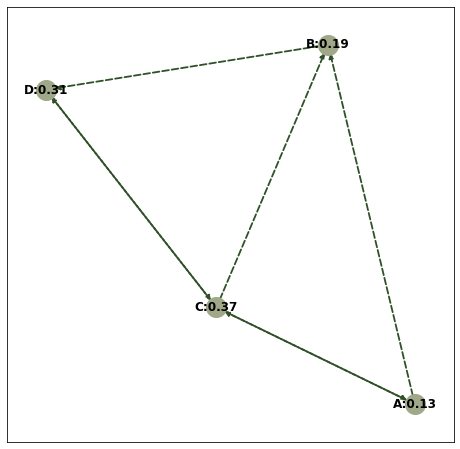

In [52]:
plt.figure(figsize=(8,8))
G = nx.DiGraph()

for nodo in power_method:
    G.add_node(nodo)

for page, outlinks in zip(pages_links['pagina'],pages_links['outlinks']):
    for outlink in outlinks:
        G.add_edge(page, outlink)

pos = nx.spring_layout(G)

labels = {}    
for node in G.nodes():
    if node in power_method:
        #set the node name as the key and the label as its value 
        labels[node] = "{}:{}".format(node,round(power_method[node],2))

# Es lo mismo que power_method pero redondeado        
print(labels)

nx.draw_networkx_nodes(G, pos, node_color='#a0a88a', node_size=400)
nx.draw_networkx_labels(G, pos, labels=labels, font_weight="bold")
nx.draw_networkx_edges(G, pos, edge_color='#305029', width=1.8, arrows = True, style='dashed')

plt.show()

Entonces podemos observar que la página con mayor puntuación es la `C`.

## Ahora intentaremos con otro set de datos (37 páginas)

[set de datos de Stanford](http://snap.stanford.edu/data/web-Stanford.html)

In [53]:
path = "../data/web-Stanford.txt"

In [54]:
def read_csv_Stanford(path, nrow=103):
    """
    Read the txt given, only works for web-Stanford 
    """
    df = pd.read_csv(path, nrows=nrow)#, usecols=['FromNode', 'ToNode'])
    # Remove the index
    df = df[3:]
    df = df.rename(columns = {'# Directed graph (each unordered pair of nodes is saved once): web-Stanford.txt ': 
                         'FromTo'})
    df[['FromNode','ToNode']] = df.FromTo.str.split('\t',expand=True) 
    df = df.drop('FromTo', axis=1)
    return df

In [55]:
df_stanford = read_csv_Stanford(path,103)

In [56]:
df_stanford

,FromNode,ToNode
3,1,6548
4,1,15409
5,6548,57031
6,15409,13102
7,2,17794
...,...,...
98,74361,226411
99,74361,239874
100,74361,255694
101,74361,264216


In [57]:
def transform_data():
    """
    Transform the nodes that are not in the FromNode and ToNode match
    This only works for 103 nrows
    """
    missing_from = list(set(df_stanford['FromNode']) - set(df_stanford['ToNode']) )
    missing_to = list(set(df_stanford['ToNode'])  - set(df_stanford['FromNode']) )
    mitad = int(len(missing_to)/2)
    for val in missing_to[:mitad]:
        df_stanford['ToNode'][df_stanford['ToNode'] == val] = missing_from[0]
    for val in missing_to[mitad:]:
        df_stanford['ToNode'][df_stanford['ToNode'] == val] = missing_from[1]

In [58]:
transform_data()

In [59]:
# Hacemos una agrupación y la lista de los outlinks
paginas_stanford = df_stanford.groupby('FromNode').aggregate(lambda tdf: tdf.unique().tolist()).reset_index()

In [60]:
paginas_stanford = paginas_stanford.rename(columns={'FromNode': 'pagina',
                                                    'ToNode': 'outlinks'})

In [61]:
paginas_stanford.head(10)

,pagina,outlinks
0,1,"[6548, 15409]"
1,100193,[2]
2,102355,[2]
3,105318,[2]
4,105730,"[2, 3]"
5,115926,[2]
6,140864,[2]
7,15409,[1]
8,163550,[2]
9,164599,[2]


In [62]:
paginas_stanford.shape

(37, 2)

In [63]:
def plot_node_graph(dataframe_pages, power_method=None, with_labels=False):
    """
    Plotea el grafo
    :param[in] dataframe_pages: dataframe de nx2
                El dataframe debe contener una columna llamada página y otra llamada outlinks;
                donde outlinks contenga una lista de los outlinks por página
    """
    nodos = dataframe_pages['pagina']

    plt.figure(figsize=(10,10))
    G = nx.DiGraph()

    for nodo in nodos:
        G.add_node(nodo)

    for page, outlinks in zip(dataframe_pages['pagina'], dataframe_pages['outlinks']):
        for outlink in outlinks:
            G.add_edge(page, outlink)

    pos = nx.spring_layout(G)


    nx.draw_networkx_nodes(G, pos, node_color='#a0a88a', node_size=400)
    if with_labels:
        labels = {}    
        for node in G.nodes():
            if node in power_method:
                #set the node name as the key and the label as its value 
                labels[node] = "{}:{}".format(node,round(power_method[node],2))
        nx.draw_networkx_labels(G, pos, labels=labels, font_weight="bold")
    else:
        nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edge_color='#305029', width=1.8, arrows = True, style='dashed')

    plt.show()
    return G

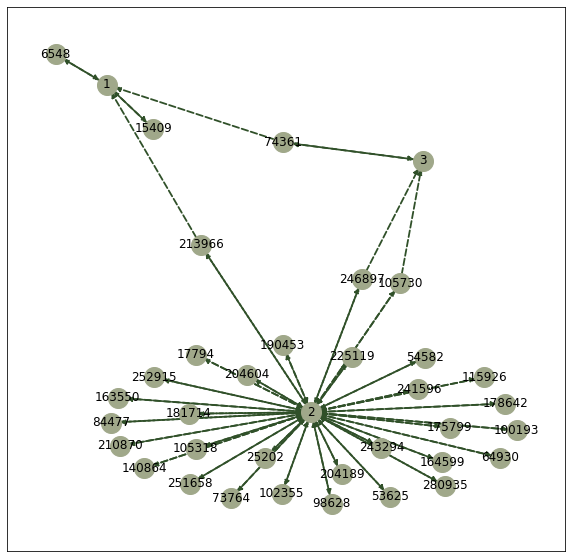

In [64]:
G37 = plot_node_graph(paginas_stanford)

#### Definimos nuestra matriz estocástica

In [65]:
def get_h_matrix(dataframe_pages):
    """
    Obtiene la matriz H, la matriz estocástica
    :param[in] dataframe_pages: dataframe de nx2
                El dataframe debe contener una columna llamada página y otra llamada outlinks;
                donde outlinks contenga una lista de los outlinks por página
    """
    sparseMatrix = csr_matrix((len(dataframe_pages), len(dataframe_pages)),  
                          dtype = np.float).toarray() 
    newdf = pd.DataFrame(sparseMatrix, columns = dataframe_pages['pagina'], index=dataframe_pages['pagina'])
    count = 0
    for page, outlinks in zip(dataframe_pages['pagina'],dataframe_pages['outlinks']):
        score = 1/len(outlinks)
        dict_page = {page: np.zeros(len(dataframe_pages))}
        for outlink in outlinks:
            newdf[page][outlink] = score
    H = newdf.to_numpy()
    return H

In [66]:
H37 = get_h_matrix(paginas_stanford)

In [67]:
H37.shape

(37, 37)

In [68]:
from networkx.algorithms.link_analysis.pagerank_alg import google_matrix

In [69]:
matrix_37 = google_matrix(G37, nodelist=paginas_stanford.pagina)

In [70]:
A_37 = matrix_37.T

### Obtenemos PageRank por el Método de la Potencia adaptado a PR

In [71]:
def power_method_pagerank(dataframe_pages, H, iteraciones):
    """
    Obtiene el pagerank 
    :param[in] dataframe_pages: dataframe de nx2
                El dataframe debe contener una columna llamada página y otra llamada outlinks;
                donde outlinks contenga una lista de los outlinks por página
    :param[in] H: Matriz estocástica
    :param[in] iteraciones: número de iteraciones a realizar
    
    :return power_method: Un diccionario con la página como llave y el pagerank como valor
    """
    # Obtenemos nuestro vector inicial
    v = np.ones(len(dataframe_pages))
    v = v*1/len(v)
    
    # Iteramos
    H = np.linalg.matrix_power(H, iteraciones)
    v_n = H@v
    
    # Convertimos a dataframe
    print(v_n.shape)
    df = pd.DataFrame(v_n.T, columns=['pagerank'])
    
    df['nodo'] = dataframe_pages['pagina']
    
    df = df.set_index('nodo')
    
    power_method = df.pagerank.to_dict()
    
    return power_method

In [72]:
power_method_dic = power_method_pagerank(paginas_stanford, A_37, iteraciones=100)

(1, 37)


In [73]:
power_method_dic

{'1': 0.10093628803480034,
 '100193': 0.013330403674657317,
 '102355': 0.013330403674657317,
 '105318': 0.013330403674657317,
 '105730': 0.013330403674657317,
 '115926': 0.013330403674657317,
 '140864': 0.013330403674657317,
 '15409': 0.04695200491257369,
 '163550': 0.013330403674657317,
 '164599': 0.013330403674657317,
 '175799': 0.013330403674657317,
 '17794': 0.013330403674657317,
 '178642': 0.013330403674657317,
 '181714': 0.013330403674657317,
 '190453': 0.013330403674657317,
 '2': 0.33831392139907474,
 '204189': 0.013330403674657317,
 '204604': 0.013330403674657317,
 '210870': 0.013330403674657317,
 '213966': 0.013330403674657317,
 '225119': 0.013330403674657317,
 '241596': 0.013330403674657317,
 '243294': 0.013330403674657317,
 '246897': 0.013330403674657317,
 '251658': 0.013330403674657317,
 '25202': 0.013330403674657317,
 '252915': 0.013330403674657317,
 '280935': 0.013330403674657317,
 '3': 0.026783358060477675,
 '53625': 0.013330403674657317,
 '54582': 0.013330403674657317,


In [74]:
# Redondeamos a 2 dígitos
power_method_round = {}    

for node in power_method_dic:
    if node in power_method_dic:
        #set the node name as the key and the label as its value 
        power_method_round[node] = round(power_method_dic[node],2)

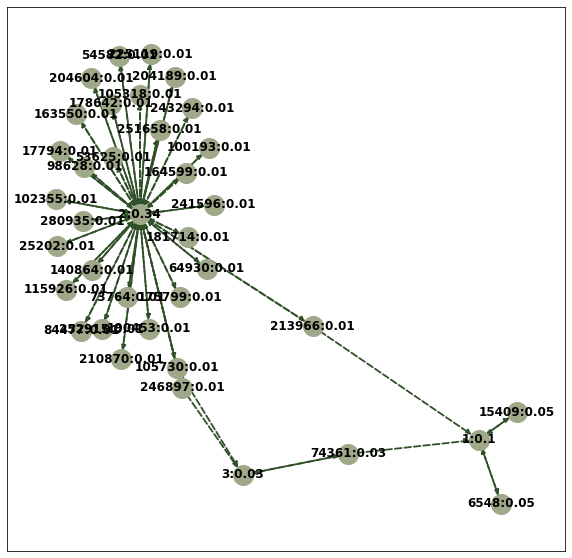

In [75]:
G37_pot = plot_node_graph(paginas_stanford, power_method=power_method_round, with_labels=True)

No se puede apreciar pero:

In [76]:
MaxKey = max(power_method_round, key=power_method_round.get)

In [77]:
print("la página con más rank es: {} con un rank de {}".format(MaxKey, power_method_round[MaxKey]))

la página con más rank es: 2 con un rank de 0.34


### Obtenemos PageRank con el paquete `Networkx`

In [78]:
PR_stanford = pagerank(G37, max_iter=1000)

In [79]:
PR_round_stanford = {} 

for node in PR_stanford:
    if node in PR_stanford:
        PR_round_stanford[node] = round(PR_stanford[node],2)

In [80]:
MaxKeyPR = max(PR_round_stanford, key=PR_round_stanford.get)

In [81]:
print("La página con más rank es: {} con un rank de {}".format(MaxKeyPR, PR_round_stanford[MaxKeyPR]))

La página con más rank es: 2 con un rank de 0.34


## Obtenemos con el Método de la Potencia visto en clase

In [82]:
def power_method_opt_pagerank(dataframe_pages, H, iteraciones):
    """
    Obtiene el pagerank 
    :param[in] dataframe_pages: dataframe de nx2
                El dataframe debe contener una columna llamada página y otra llamada outlinks;
                donde outlinks contenga una lista de los outlinks por página
    :param[in] H: Matriz estocástica
    :param[in] iteraciones: número de iteraciones a realizar
    
    :return power_method: Un diccionario con la página como llave y el pagerank como valor
    """
    # Obtenemos nuestro vector inicial
    v = np.ones(len(dataframe_pages))
    v = v*1/len(v)
    
    n = len(v)
    q_k = v
    q_k = q_k.reshape(n,1)
    max_iter = iteraciones

    for k in range(max_iter):
        z_k = H@q_k
        q_k = z_k/np.linalg.norm(z_k)
        lambda_k = q_k.T @ H @ q_k
    
    # Convertimos a dataframe
    df = pd.DataFrame(q_k, columns=['pagerank'])
    
    df['nodo'] = dataframe_pages['pagina']
    
    df = df.set_index('nodo')
    
    power_method_opt = df.pagerank.to_dict()
    
    return power_method_opt

In [83]:
power_method_opt_dictionary = power_method_opt_pagerank(paginas_stanford, A_37, iteraciones=100)

In [84]:
MaxKey_pot_opt = max(power_method_opt_dictionary, key=power_method_opt_dictionary.get)

In [85]:
print("La página con más rank es: {} con un rank de {}".format(MaxKey_pot_opt, power_method_opt_dictionary[MaxKey_pot_opt]))

La página con más rank es: 2 con un rank de 0.9173865700385999


## Comparando resultados

In [111]:
eigvector_comparison_37 = pd.DataFrame({"Página": PR_round_stanford.keys(),
                                    "NX PageRank": PR_round_stanford.values(),
                                    "Potencia PR": power_method_round.values(),
                                    "Potencia OPT-2020": power_method_opt_dictionary.values()}
                                    #"LinAlg": eigvec_eig[:,0].real}
                                    ).reset_index().iloc[:,1:]
eigvector_comparison_37

,Página,NX PageRank,Potencia PR,Potencia OPT-2020
0,1,0.10,0.10,0.273703
1,100193,0.01,0.01,0.036147
2,102355,0.01,0.01,0.036147
3,105318,0.01,0.01,0.036147
4,105730,0.01,0.01,0.036147
5,115926,0.01,0.01,0.036147
6,140864,0.01,0.01,0.036147
7,15409,0.05,0.05,0.127317
8,163550,0.01,0.01,0.036147
9,164599,0.01,0.01,0.036147


## Nota: 

Para obtener los mismos resultados con tres algoritmos (NetworkX, método de la potencia adaptado, y método de la potencia visto en clase), fue necesario generar la matriz de Google a partir de la matriz de adyacencias. Los algoritmos del método de la potencia se aplicaron sobre la matriz de Google para obtener su eigenvector, de esta manera, los 3 algoritmos identificaron a la página "2" como la de mayor rank.


La matriz de Google considera el factor de amortiguación a los nodos que no tienen outlinks, lo que ayuda a que no se vean beneficiados por lo mismo. Sin aplicar la matriz de Google, los métodos de la potencia identificaban al nodo "74361" como el de mayor rank; se puede apreciar en el grafo que ese nodo no cuenta con outlinks, y sí cuenta con varios inlinks. Sin embargo, intuitivamente a partir del grafo, se puede apreciar que el nodo "2" debería ser el que tiene mayor Rank. La función de `pagerank` de NetworkX ya considera un factor de amortiguación por default, por lo que arrojaba un resultado distinto al de los métodos de la potencia sin ser aplicados a la matriz de Google.


Desgraciadamente, no fue posible utilizar el algoritmo desarrollado por el equipo durante la práctia 1.2 para obtener los eigenvalores a partir de la factorización QR para la matriz de adyacencias de 37 páginas.

## Obtenemos con el algoritmo QR implementado en la Práctica 1.2

In [112]:
eigval37, eigvec37 = Eig_Householder(A_37)

LinAlgError: Last 2 dimensions of the array must be square

## Referencias

- [Google Matrix](https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.google_matrix.html#networkx.algorithms.link_analysis.pagerank_alg.google_matrix)
- [Código QR](https://github.com/optimizacion-2020-2-gh-classroom/practica-1-segunda-parte-graph-caroacostatovany)
- [PageRank](https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html)
- [Etiquetas para los nodos](https://stackoverflow.com/questions/14665767/networkx-specific-nodes-labeling)
- [set de datos de Stanford](http://snap.stanford.edu/data/web-Stanford.html)